***
    
Demo EvoJAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving convection-diffusion equation (1D linear convection)
    
    2. Optimize PINN using xNES + NAG solver in the JAX framework
<!--        -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022). -->

# Demo

In [1]:
# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# import library
import numpy as np
import time

# import problem
from convection_diffusion import get_fitness, policy # Number of parameters: 250

xNES +NAG Solver

In [2]:
from jax import random, numpy as jnp
from jax.scipy.linalg import expm
from jax import jit, vmap
seed = 1
def xNES_NAG(f, x0, bs=20, lr=1e-3, sigma=1, maxtime=60, momentum_coeff=0.9, verbose=False):
    
    """ [xNES_NAG]
    Implemented baseline algo.: Exponential NES (xNES) as described in Glasmachers, Schaul, Sun, Wierstra and Schmidhuber (GECCO'10).
    Maximizes a function f. Returns (best solution found, corresponding fitness, etc.).
    
    Added Nesterov Accelerated Gradient (NAG) 
    """
    # Initialize random generator (+ seed)
    
    key, rng = random.split(random.PRNGKey(seed))
    
    # target search
    center = x0.copy()
    dim = len(x0)
    I = jnp.eye(dim)
    A = I * sigma
    momentum = jnp.zeros(dim)
    bestFitness = -jnp.inf    
    learningRate = lr     # a same learning rate apply to all updates (including mixture model coef.)
    batchSize = bs    
    bestFound = None
    bestFitness = -jnp.inf
    
    loss_ls = []
    t_training_ls = []
    
    @jit
    def project_sample(center, A, momentum, rng):
        center_proj = center + momentum_coeff * momentum
        # produce and evaluate samples
        key, rng = random.split(rng) # update random generator
        samples = random.normal(key, [batchSize, dim])
        samples_o = jnp.dot(samples, A) + center_proj
        return (samples, samples_o, rng)

    @jit
    def computeUtilities(fitnesses):
        l = jnp.argsort(fitnesses)
        ranks = jnp.argsort(l)
        L = fitnesses.size
        # smooth reshaping
        utilities = jnp.array([jnp.maximum(0., x) for x in jnp.log(L / 2. + 1.0) - jnp.log(L - jnp.array(ranks))])
        utilities /= sum(utilities)       # make the utilities sum to 1
        utilities -= 1. / L  # baseline
        return utilities

    @jit
    def update_parameters(center, A, momentum, utilities, samples):    
        # NAG parameter updates
        update_center = jnp.dot(A, jnp.dot(utilities, samples)) + momentum_coeff * momentum
        momentum = update_center
        # update center and variances
        center += update_center   
        covGradient = sum([u * (jnp.outer(s, s) - I) for (s, u) in zip(samples, utilities)])
        A = jnp.dot(A, expm(0.5 * learningRate * covGradient))
        return (center, A, momentum)
  
    
    # loop
    numEvals = 0
    t_training = 0
    while t_training <= maxtime:
        start = time.time()
        # do partial update (project into new center) & produce samples
        samples, samples_o, rng = project_sample(center, A, momentum, rng)        
        # evaluate sample fitness
        fitnesses = f(samples_o)
        # return best fitness and solution
        if max(fitnesses) > bestFitness:
            _bestFitness = jnp.argmax(fitnesses)
            bestFitness, bestFound = fitnesses[_bestFitness], samples_o[_bestFitness]
        # update no. evaluations 
        numEvals += batchSize
        # print progress
        if verbose:
            print ("Step %5d | lr %.1e | numEvals %7d  : %.3e   [Best: %.5e]" %(numEvals/batchSize, lr, numEvals,
                                                                                max(fitnesses), bestFitness))        
        
        # fitness shaping
        utilities = computeUtilities(fitnesses)
        # parameter updates
        center, A, momentum = update_parameters(center, A, momentum, utilities, samples)
        end = time.time()
        t_training += (end-start)
        
        t_training_ls.append(t_training)
        loss_ls.append(bestFitness)
        
    print("...\nRunning time: %d secs!" %(t_training))
    print("\nNo of iterations: %d iterations!" %(numEvals/batchSize))
    return bestFound, bestFitness, numEvals, t_training_ls, loss_ls


Training

In [3]:
# optimize PINN (no source -> xNES)
w0 = jnp.zeros(policy.num_params)
op_weight, op_fitness, evals, t_training_ls, loss_ls = xNES_NAG(get_fitness, w0, bs=100, lr=0.01, sigma=0.001, momentum_coeff=0.99, verbose=True)

Step     1 | lr 1.0e-02 | numEvals     100  : -5.000e-01   [Best: -4.99991e-01]
Step     2 | lr 1.0e-02 | numEvals     200  : -5.000e-01   [Best: -4.99991e-01]
Step     3 | lr 1.0e-02 | numEvals     300  : -5.000e-01   [Best: -4.99984e-01]
Step     4 | lr 1.0e-02 | numEvals     400  : -5.000e-01   [Best: -4.99969e-01]
Step     5 | lr 1.0e-02 | numEvals     500  : -4.999e-01   [Best: -4.99925e-01]
Step     6 | lr 1.0e-02 | numEvals     600  : -4.999e-01   [Best: -4.99851e-01]
Step     7 | lr 1.0e-02 | numEvals     700  : -4.997e-01   [Best: -4.99696e-01]
Step     8 | lr 1.0e-02 | numEvals     800  : -4.995e-01   [Best: -4.99463e-01]
Step     9 | lr 1.0e-02 | numEvals     900  : -4.991e-01   [Best: -4.99138e-01]
Step    10 | lr 1.0e-02 | numEvals    1000  : -4.986e-01   [Best: -4.98645e-01]
Step    11 | lr 1.0e-02 | numEvals    1100  : -4.980e-01   [Best: -4.97986e-01]
Step    12 | lr 1.0e-02 | numEvals    1200  : -4.971e-01   [Best: -4.97050e-01]
Step    13 | lr 1.0e-02 | numEvals    13

Step   104 | lr 1.0e-02 | numEvals   10400  : -2.972e-01   [Best: -2.49311e-01]
Step   105 | lr 1.0e-02 | numEvals   10500  : -2.939e-01   [Best: -2.49311e-01]
Step   106 | lr 1.0e-02 | numEvals   10600  : -2.903e-01   [Best: -2.49311e-01]
Step   107 | lr 1.0e-02 | numEvals   10700  : -2.857e-01   [Best: -2.49311e-01]
Step   108 | lr 1.0e-02 | numEvals   10800  : -2.810e-01   [Best: -2.49311e-01]
Step   109 | lr 1.0e-02 | numEvals   10900  : -2.755e-01   [Best: -2.49311e-01]
Step   110 | lr 1.0e-02 | numEvals   11000  : -2.702e-01   [Best: -2.49311e-01]
Step   111 | lr 1.0e-02 | numEvals   11100  : -2.644e-01   [Best: -2.49311e-01]
Step   112 | lr 1.0e-02 | numEvals   11200  : -2.598e-01   [Best: -2.49311e-01]
Step   113 | lr 1.0e-02 | numEvals   11300  : -2.549e-01   [Best: -2.49311e-01]
Step   114 | lr 1.0e-02 | numEvals   11400  : -2.514e-01   [Best: -2.49311e-01]
Step   115 | lr 1.0e-02 | numEvals   11500  : -2.489e-01   [Best: -2.48933e-01]
Step   116 | lr 1.0e-02 | numEvals   116

Step   210 | lr 1.0e-02 | numEvals   21000  : -2.483e-01   [Best: -2.48277e-01]
Step   211 | lr 1.0e-02 | numEvals   21100  : -2.483e-01   [Best: -2.48271e-01]
Step   212 | lr 1.0e-02 | numEvals   21200  : -2.483e-01   [Best: -2.48257e-01]
Step   213 | lr 1.0e-02 | numEvals   21300  : -2.483e-01   [Best: -2.48253e-01]
Step   214 | lr 1.0e-02 | numEvals   21400  : -2.482e-01   [Best: -2.48240e-01]
Step   215 | lr 1.0e-02 | numEvals   21500  : -2.482e-01   [Best: -2.48234e-01]
Step   216 | lr 1.0e-02 | numEvals   21600  : -2.482e-01   [Best: -2.48224e-01]
Step   217 | lr 1.0e-02 | numEvals   21700  : -2.482e-01   [Best: -2.48214e-01]
Step   218 | lr 1.0e-02 | numEvals   21800  : -2.482e-01   [Best: -2.48203e-01]
Step   219 | lr 1.0e-02 | numEvals   21900  : -2.482e-01   [Best: -2.48193e-01]
Step   220 | lr 1.0e-02 | numEvals   22000  : -2.482e-01   [Best: -2.48186e-01]
Step   221 | lr 1.0e-02 | numEvals   22100  : -2.482e-01   [Best: -2.48168e-01]
Step   222 | lr 1.0e-02 | numEvals   222

Step   320 | lr 1.0e-02 | numEvals   32000  : -2.480e-01   [Best: -2.47636e-01]
Step   321 | lr 1.0e-02 | numEvals   32100  : -2.480e-01   [Best: -2.47636e-01]
Step   322 | lr 1.0e-02 | numEvals   32200  : -2.480e-01   [Best: -2.47636e-01]
Step   323 | lr 1.0e-02 | numEvals   32300  : -2.479e-01   [Best: -2.47636e-01]
Step   324 | lr 1.0e-02 | numEvals   32400  : -2.479e-01   [Best: -2.47636e-01]
Step   325 | lr 1.0e-02 | numEvals   32500  : -2.479e-01   [Best: -2.47636e-01]
Step   326 | lr 1.0e-02 | numEvals   32600  : -2.479e-01   [Best: -2.47636e-01]
Step   327 | lr 1.0e-02 | numEvals   32700  : -2.479e-01   [Best: -2.47636e-01]
Step   328 | lr 1.0e-02 | numEvals   32800  : -2.479e-01   [Best: -2.47636e-01]
Step   329 | lr 1.0e-02 | numEvals   32900  : -2.478e-01   [Best: -2.47636e-01]
Step   330 | lr 1.0e-02 | numEvals   33000  : -2.478e-01   [Best: -2.47636e-01]
Step   331 | lr 1.0e-02 | numEvals   33100  : -2.478e-01   [Best: -2.47636e-01]
Step   332 | lr 1.0e-02 | numEvals   332

Step   433 | lr 1.0e-02 | numEvals   43300  : -2.477e-01   [Best: -2.47466e-01]
Step   434 | lr 1.0e-02 | numEvals   43400  : -2.477e-01   [Best: -2.47466e-01]
Step   435 | lr 1.0e-02 | numEvals   43500  : -2.476e-01   [Best: -2.47466e-01]
Step   436 | lr 1.0e-02 | numEvals   43600  : -2.476e-01   [Best: -2.47466e-01]
Step   437 | lr 1.0e-02 | numEvals   43700  : -2.477e-01   [Best: -2.47466e-01]
Step   438 | lr 1.0e-02 | numEvals   43800  : -2.476e-01   [Best: -2.47466e-01]
Step   439 | lr 1.0e-02 | numEvals   43900  : -2.475e-01   [Best: -2.47466e-01]
Step   440 | lr 1.0e-02 | numEvals   44000  : -2.476e-01   [Best: -2.47466e-01]
Step   441 | lr 1.0e-02 | numEvals   44100  : -2.476e-01   [Best: -2.47466e-01]
Step   442 | lr 1.0e-02 | numEvals   44200  : -2.475e-01   [Best: -2.47466e-01]
Step   443 | lr 1.0e-02 | numEvals   44300  : -2.475e-01   [Best: -2.47466e-01]
Step   444 | lr 1.0e-02 | numEvals   44400  : -2.475e-01   [Best: -2.47466e-01]
Step   445 | lr 1.0e-02 | numEvals   445

Step   544 | lr 1.0e-02 | numEvals   54400  : -2.469e-01   [Best: -2.46907e-01]
Step   545 | lr 1.0e-02 | numEvals   54500  : -2.470e-01   [Best: -2.46907e-01]
Step   546 | lr 1.0e-02 | numEvals   54600  : -2.470e-01   [Best: -2.46907e-01]
Step   547 | lr 1.0e-02 | numEvals   54700  : -2.471e-01   [Best: -2.46907e-01]
Step   548 | lr 1.0e-02 | numEvals   54800  : -2.470e-01   [Best: -2.46907e-01]
Step   549 | lr 1.0e-02 | numEvals   54900  : -2.470e-01   [Best: -2.46907e-01]
Step   550 | lr 1.0e-02 | numEvals   55000  : -2.470e-01   [Best: -2.46907e-01]
Step   551 | lr 1.0e-02 | numEvals   55100  : -2.471e-01   [Best: -2.46907e-01]
Step   552 | lr 1.0e-02 | numEvals   55200  : -2.470e-01   [Best: -2.46907e-01]
Step   553 | lr 1.0e-02 | numEvals   55300  : -2.471e-01   [Best: -2.46907e-01]
Step   554 | lr 1.0e-02 | numEvals   55400  : -2.470e-01   [Best: -2.46907e-01]
Step   555 | lr 1.0e-02 | numEvals   55500  : -2.470e-01   [Best: -2.46907e-01]
Step   556 | lr 1.0e-02 | numEvals   556

Step   651 | lr 1.0e-02 | numEvals   65100  : -2.473e-01   [Best: -2.46736e-01]
Step   652 | lr 1.0e-02 | numEvals   65200  : -2.474e-01   [Best: -2.46736e-01]
Step   653 | lr 1.0e-02 | numEvals   65300  : -2.473e-01   [Best: -2.46736e-01]
Step   654 | lr 1.0e-02 | numEvals   65400  : -2.474e-01   [Best: -2.46736e-01]
Step   655 | lr 1.0e-02 | numEvals   65500  : -2.476e-01   [Best: -2.46736e-01]
Step   656 | lr 1.0e-02 | numEvals   65600  : -2.474e-01   [Best: -2.46736e-01]
Step   657 | lr 1.0e-02 | numEvals   65700  : -2.474e-01   [Best: -2.46736e-01]
Step   658 | lr 1.0e-02 | numEvals   65800  : -2.471e-01   [Best: -2.46736e-01]
Step   659 | lr 1.0e-02 | numEvals   65900  : -2.472e-01   [Best: -2.46736e-01]
Step   660 | lr 1.0e-02 | numEvals   66000  : -2.470e-01   [Best: -2.46736e-01]
Step   661 | lr 1.0e-02 | numEvals   66100  : -2.471e-01   [Best: -2.46736e-01]
Step   662 | lr 1.0e-02 | numEvals   66200  : -2.470e-01   [Best: -2.46736e-01]
Step   663 | lr 1.0e-02 | numEvals   663

Step   756 | lr 1.0e-02 | numEvals   75600  : -2.473e-01   [Best: -2.46736e-01]
Step   757 | lr 1.0e-02 | numEvals   75700  : -2.472e-01   [Best: -2.46736e-01]
Step   758 | lr 1.0e-02 | numEvals   75800  : -2.471e-01   [Best: -2.46736e-01]
Step   759 | lr 1.0e-02 | numEvals   75900  : -2.473e-01   [Best: -2.46736e-01]
Step   760 | lr 1.0e-02 | numEvals   76000  : -2.473e-01   [Best: -2.46736e-01]
Step   761 | lr 1.0e-02 | numEvals   76100  : -2.473e-01   [Best: -2.46736e-01]
Step   762 | lr 1.0e-02 | numEvals   76200  : -2.472e-01   [Best: -2.46736e-01]
Step   763 | lr 1.0e-02 | numEvals   76300  : -2.472e-01   [Best: -2.46736e-01]
Step   764 | lr 1.0e-02 | numEvals   76400  : -2.472e-01   [Best: -2.46736e-01]
Step   765 | lr 1.0e-02 | numEvals   76500  : -2.472e-01   [Best: -2.46736e-01]
Step   766 | lr 1.0e-02 | numEvals   76600  : -2.472e-01   [Best: -2.46736e-01]
Step   767 | lr 1.0e-02 | numEvals   76700  : -2.473e-01   [Best: -2.46736e-01]
Step   768 | lr 1.0e-02 | numEvals   768

Step   863 | lr 1.0e-02 | numEvals   86300  : -2.470e-01   [Best: -2.46736e-01]
Step   864 | lr 1.0e-02 | numEvals   86400  : -2.472e-01   [Best: -2.46736e-01]
Step   865 | lr 1.0e-02 | numEvals   86500  : -2.472e-01   [Best: -2.46736e-01]
Step   866 | lr 1.0e-02 | numEvals   86600  : -2.469e-01   [Best: -2.46736e-01]
Step   867 | lr 1.0e-02 | numEvals   86700  : -2.470e-01   [Best: -2.46736e-01]
Step   868 | lr 1.0e-02 | numEvals   86800  : -2.469e-01   [Best: -2.46736e-01]
Step   869 | lr 1.0e-02 | numEvals   86900  : -2.471e-01   [Best: -2.46736e-01]
Step   870 | lr 1.0e-02 | numEvals   87000  : -2.469e-01   [Best: -2.46736e-01]
Step   871 | lr 1.0e-02 | numEvals   87100  : -2.471e-01   [Best: -2.46736e-01]
Step   872 | lr 1.0e-02 | numEvals   87200  : -2.470e-01   [Best: -2.46736e-01]
Step   873 | lr 1.0e-02 | numEvals   87300  : -2.467e-01   [Best: -2.46720e-01]
Step   874 | lr 1.0e-02 | numEvals   87400  : -2.468e-01   [Best: -2.46720e-01]
Step   875 | lr 1.0e-02 | numEvals   875

Step   968 | lr 1.0e-02 | numEvals   96800  : -2.460e-01   [Best: -2.45668e-01]
Step   969 | lr 1.0e-02 | numEvals   96900  : -2.459e-01   [Best: -2.45668e-01]
Step   970 | lr 1.0e-02 | numEvals   97000  : -2.459e-01   [Best: -2.45668e-01]
Step   971 | lr 1.0e-02 | numEvals   97100  : -2.460e-01   [Best: -2.45668e-01]
Step   972 | lr 1.0e-02 | numEvals   97200  : -2.459e-01   [Best: -2.45668e-01]
Step   973 | lr 1.0e-02 | numEvals   97300  : -2.459e-01   [Best: -2.45668e-01]
Step   974 | lr 1.0e-02 | numEvals   97400  : -2.459e-01   [Best: -2.45668e-01]
Step   975 | lr 1.0e-02 | numEvals   97500  : -2.460e-01   [Best: -2.45668e-01]
Step   976 | lr 1.0e-02 | numEvals   97600  : -2.458e-01   [Best: -2.45668e-01]
Step   977 | lr 1.0e-02 | numEvals   97700  : -2.460e-01   [Best: -2.45668e-01]
Step   978 | lr 1.0e-02 | numEvals   97800  : -2.460e-01   [Best: -2.45668e-01]
Step   979 | lr 1.0e-02 | numEvals   97900  : -2.457e-01   [Best: -2.45668e-01]
Step   980 | lr 1.0e-02 | numEvals   980

Step  1073 | lr 1.0e-02 | numEvals  107300  : -2.464e-01   [Best: -2.45619e-01]
Step  1074 | lr 1.0e-02 | numEvals  107400  : -2.467e-01   [Best: -2.45619e-01]
Step  1075 | lr 1.0e-02 | numEvals  107500  : -2.465e-01   [Best: -2.45619e-01]
Step  1076 | lr 1.0e-02 | numEvals  107600  : -2.463e-01   [Best: -2.45619e-01]
Step  1077 | lr 1.0e-02 | numEvals  107700  : -2.465e-01   [Best: -2.45619e-01]
Step  1078 | lr 1.0e-02 | numEvals  107800  : -2.465e-01   [Best: -2.45619e-01]
Step  1079 | lr 1.0e-02 | numEvals  107900  : -2.462e-01   [Best: -2.45619e-01]
Step  1080 | lr 1.0e-02 | numEvals  108000  : -2.465e-01   [Best: -2.45619e-01]
Step  1081 | lr 1.0e-02 | numEvals  108100  : -2.462e-01   [Best: -2.45619e-01]
Step  1082 | lr 1.0e-02 | numEvals  108200  : -2.463e-01   [Best: -2.45619e-01]
Step  1083 | lr 1.0e-02 | numEvals  108300  : -2.464e-01   [Best: -2.45619e-01]
Step  1084 | lr 1.0e-02 | numEvals  108400  : -2.461e-01   [Best: -2.45619e-01]
Step  1085 | lr 1.0e-02 | numEvals  1085

Step  1186 | lr 1.0e-02 | numEvals  118600  : -2.462e-01   [Best: -2.45563e-01]
Step  1187 | lr 1.0e-02 | numEvals  118700  : -2.463e-01   [Best: -2.45563e-01]
Step  1188 | lr 1.0e-02 | numEvals  118800  : -2.459e-01   [Best: -2.45563e-01]
Step  1189 | lr 1.0e-02 | numEvals  118900  : -2.461e-01   [Best: -2.45563e-01]
Step  1190 | lr 1.0e-02 | numEvals  119000  : -2.461e-01   [Best: -2.45563e-01]
Step  1191 | lr 1.0e-02 | numEvals  119100  : -2.460e-01   [Best: -2.45563e-01]
Step  1192 | lr 1.0e-02 | numEvals  119200  : -2.459e-01   [Best: -2.45563e-01]
Step  1193 | lr 1.0e-02 | numEvals  119300  : -2.459e-01   [Best: -2.45563e-01]
Step  1194 | lr 1.0e-02 | numEvals  119400  : -2.461e-01   [Best: -2.45563e-01]
Step  1195 | lr 1.0e-02 | numEvals  119500  : -2.463e-01   [Best: -2.45563e-01]
Step  1196 | lr 1.0e-02 | numEvals  119600  : -2.461e-01   [Best: -2.45563e-01]
Step  1197 | lr 1.0e-02 | numEvals  119700  : -2.461e-01   [Best: -2.45563e-01]
Step  1198 | lr 1.0e-02 | numEvals  1198

Step  1298 | lr 1.0e-02 | numEvals  129800  : -2.438e-01   [Best: -2.43743e-01]
Step  1299 | lr 1.0e-02 | numEvals  129900  : -2.430e-01   [Best: -2.43017e-01]
Step  1300 | lr 1.0e-02 | numEvals  130000  : -2.431e-01   [Best: -2.43017e-01]
Step  1301 | lr 1.0e-02 | numEvals  130100  : -2.430e-01   [Best: -2.43003e-01]
Step  1302 | lr 1.0e-02 | numEvals  130200  : -2.433e-01   [Best: -2.43003e-01]
Step  1303 | lr 1.0e-02 | numEvals  130300  : -2.428e-01   [Best: -2.42796e-01]
Step  1304 | lr 1.0e-02 | numEvals  130400  : -2.433e-01   [Best: -2.42796e-01]
Step  1305 | lr 1.0e-02 | numEvals  130500  : -2.432e-01   [Best: -2.42796e-01]
Step  1306 | lr 1.0e-02 | numEvals  130600  : -2.428e-01   [Best: -2.42769e-01]
Step  1307 | lr 1.0e-02 | numEvals  130700  : -2.430e-01   [Best: -2.42769e-01]
Step  1308 | lr 1.0e-02 | numEvals  130800  : -2.426e-01   [Best: -2.42590e-01]
Step  1309 | lr 1.0e-02 | numEvals  130900  : -2.429e-01   [Best: -2.42590e-01]
Step  1310 | lr 1.0e-02 | numEvals  1310

Step  1408 | lr 1.0e-02 | numEvals  140800  : -4.079e-02   [Best: -4.07890e-02]
Step  1409 | lr 1.0e-02 | numEvals  140900  : -3.747e-02   [Best: -3.74663e-02]
Step  1410 | lr 1.0e-02 | numEvals  141000  : -3.577e-02   [Best: -3.57727e-02]
Step  1411 | lr 1.0e-02 | numEvals  141100  : -3.506e-02   [Best: -3.50628e-02]
Step  1412 | lr 1.0e-02 | numEvals  141200  : -3.544e-02   [Best: -3.50628e-02]
Step  1413 | lr 1.0e-02 | numEvals  141300  : -3.660e-02   [Best: -3.50628e-02]
Step  1414 | lr 1.0e-02 | numEvals  141400  : -3.755e-02   [Best: -3.50628e-02]
Step  1415 | lr 1.0e-02 | numEvals  141500  : -3.811e-02   [Best: -3.50628e-02]
Step  1416 | lr 1.0e-02 | numEvals  141600  : -3.652e-02   [Best: -3.50628e-02]
Step  1417 | lr 1.0e-02 | numEvals  141700  : -3.662e-02   [Best: -3.50628e-02]
Step  1418 | lr 1.0e-02 | numEvals  141800  : -3.200e-02   [Best: -3.20029e-02]
Step  1419 | lr 1.0e-02 | numEvals  141900  : -2.842e-02   [Best: -2.84212e-02]
Step  1420 | lr 1.0e-02 | numEvals  1420

Step  1513 | lr 1.0e-02 | numEvals  151300  : -2.768e-04   [Best: -1.22392e-04]
Step  1514 | lr 1.0e-02 | numEvals  151400  : -2.715e-04   [Best: -1.22392e-04]
Step  1515 | lr 1.0e-02 | numEvals  151500  : -3.092e-04   [Best: -1.22392e-04]
Step  1516 | lr 1.0e-02 | numEvals  151600  : -3.113e-04   [Best: -1.22392e-04]
Step  1517 | lr 1.0e-02 | numEvals  151700  : -3.306e-04   [Best: -1.22392e-04]
Step  1518 | lr 1.0e-02 | numEvals  151800  : -3.200e-04   [Best: -1.22392e-04]
Step  1519 | lr 1.0e-02 | numEvals  151900  : -3.434e-04   [Best: -1.22392e-04]
Step  1520 | lr 1.0e-02 | numEvals  152000  : -4.105e-04   [Best: -1.22392e-04]
Step  1521 | lr 1.0e-02 | numEvals  152100  : -3.914e-04   [Best: -1.22392e-04]
Step  1522 | lr 1.0e-02 | numEvals  152200  : -4.240e-04   [Best: -1.22392e-04]
Step  1523 | lr 1.0e-02 | numEvals  152300  : -4.963e-04   [Best: -1.22392e-04]
Step  1524 | lr 1.0e-02 | numEvals  152400  : -5.225e-04   [Best: -1.22392e-04]
Step  1525 | lr 1.0e-02 | numEvals  1525

Step  1617 | lr 1.0e-02 | numEvals  161700  : -2.637e-04   [Best: -1.22392e-04]
Step  1618 | lr 1.0e-02 | numEvals  161800  : -2.687e-04   [Best: -1.22392e-04]
Step  1619 | lr 1.0e-02 | numEvals  161900  : -2.905e-04   [Best: -1.22392e-04]
Step  1620 | lr 1.0e-02 | numEvals  162000  : -2.732e-04   [Best: -1.22392e-04]
Step  1621 | lr 1.0e-02 | numEvals  162100  : -3.397e-04   [Best: -1.22392e-04]
Step  1622 | lr 1.0e-02 | numEvals  162200  : -3.639e-04   [Best: -1.22392e-04]
Step  1623 | lr 1.0e-02 | numEvals  162300  : -3.838e-04   [Best: -1.22392e-04]
Step  1624 | lr 1.0e-02 | numEvals  162400  : -3.318e-04   [Best: -1.22392e-04]
Step  1625 | lr 1.0e-02 | numEvals  162500  : -3.462e-04   [Best: -1.22392e-04]
Step  1626 | lr 1.0e-02 | numEvals  162600  : -4.008e-04   [Best: -1.22392e-04]
Step  1627 | lr 1.0e-02 | numEvals  162700  : -4.094e-04   [Best: -1.22392e-04]
Step  1628 | lr 1.0e-02 | numEvals  162800  : -3.840e-04   [Best: -1.22392e-04]
Step  1629 | lr 1.0e-02 | numEvals  1629

Step  1721 | lr 1.0e-02 | numEvals  172100  : -1.804e-04   [Best: -1.22392e-04]
Step  1722 | lr 1.0e-02 | numEvals  172200  : -2.243e-04   [Best: -1.22392e-04]
Step  1723 | lr 1.0e-02 | numEvals  172300  : -2.098e-04   [Best: -1.22392e-04]
Step  1724 | lr 1.0e-02 | numEvals  172400  : -1.570e-04   [Best: -1.22392e-04]
Step  1725 | lr 1.0e-02 | numEvals  172500  : -1.734e-04   [Best: -1.22392e-04]
Step  1726 | lr 1.0e-02 | numEvals  172600  : -1.933e-04   [Best: -1.22392e-04]
Step  1727 | lr 1.0e-02 | numEvals  172700  : -1.409e-04   [Best: -1.22392e-04]
Step  1728 | lr 1.0e-02 | numEvals  172800  : -1.596e-04   [Best: -1.22392e-04]
Step  1729 | lr 1.0e-02 | numEvals  172900  : -1.362e-04   [Best: -1.22392e-04]
Step  1730 | lr 1.0e-02 | numEvals  173000  : -2.023e-04   [Best: -1.22392e-04]
Step  1731 | lr 1.0e-02 | numEvals  173100  : -1.382e-04   [Best: -1.22392e-04]
Step  1732 | lr 1.0e-02 | numEvals  173200  : -1.570e-04   [Best: -1.22392e-04]
Step  1733 | lr 1.0e-02 | numEvals  1733

Step  1826 | lr 1.0e-02 | numEvals  182600  : -3.196e-04   [Best: -1.22392e-04]
Step  1827 | lr 1.0e-02 | numEvals  182700  : -3.478e-04   [Best: -1.22392e-04]
Step  1828 | lr 1.0e-02 | numEvals  182800  : -3.399e-04   [Best: -1.22392e-04]
Step  1829 | lr 1.0e-02 | numEvals  182900  : -3.176e-04   [Best: -1.22392e-04]
Step  1830 | lr 1.0e-02 | numEvals  183000  : -2.800e-04   [Best: -1.22392e-04]
Step  1831 | lr 1.0e-02 | numEvals  183100  : -2.946e-04   [Best: -1.22392e-04]
Step  1832 | lr 1.0e-02 | numEvals  183200  : -2.948e-04   [Best: -1.22392e-04]
Step  1833 | lr 1.0e-02 | numEvals  183300  : -2.916e-04   [Best: -1.22392e-04]
Step  1834 | lr 1.0e-02 | numEvals  183400  : -3.132e-04   [Best: -1.22392e-04]
Step  1835 | lr 1.0e-02 | numEvals  183500  : -3.260e-04   [Best: -1.22392e-04]
Step  1836 | lr 1.0e-02 | numEvals  183600  : -3.658e-04   [Best: -1.22392e-04]
Step  1837 | lr 1.0e-02 | numEvals  183700  : -3.620e-04   [Best: -1.22392e-04]
Step  1838 | lr 1.0e-02 | numEvals  1838

Step  1933 | lr 1.0e-02 | numEvals  193300  : -2.524e-04   [Best: -1.22392e-04]
Step  1934 | lr 1.0e-02 | numEvals  193400  : -2.758e-04   [Best: -1.22392e-04]
Step  1935 | lr 1.0e-02 | numEvals  193500  : -2.929e-04   [Best: -1.22392e-04]
Step  1936 | lr 1.0e-02 | numEvals  193600  : -3.422e-04   [Best: -1.22392e-04]
Step  1937 | lr 1.0e-02 | numEvals  193700  : -2.927e-04   [Best: -1.22392e-04]
Step  1938 | lr 1.0e-02 | numEvals  193800  : -3.564e-04   [Best: -1.22392e-04]
Step  1939 | lr 1.0e-02 | numEvals  193900  : -3.044e-04   [Best: -1.22392e-04]
Step  1940 | lr 1.0e-02 | numEvals  194000  : -2.378e-04   [Best: -1.22392e-04]
Step  1941 | lr 1.0e-02 | numEvals  194100  : -2.926e-04   [Best: -1.22392e-04]
Step  1942 | lr 1.0e-02 | numEvals  194200  : -2.946e-04   [Best: -1.22392e-04]
Step  1943 | lr 1.0e-02 | numEvals  194300  : -2.074e-04   [Best: -1.22392e-04]
Step  1944 | lr 1.0e-02 | numEvals  194400  : -2.258e-04   [Best: -1.22392e-04]
Step  1945 | lr 1.0e-02 | numEvals  1945

Step  2037 | lr 1.0e-02 | numEvals  203700  : -2.666e-04   [Best: -9.49342e-05]
Step  2038 | lr 1.0e-02 | numEvals  203800  : -1.981e-04   [Best: -9.49342e-05]
Step  2039 | lr 1.0e-02 | numEvals  203900  : -2.567e-04   [Best: -9.49342e-05]
Step  2040 | lr 1.0e-02 | numEvals  204000  : -3.925e-04   [Best: -9.49342e-05]
Step  2041 | lr 1.0e-02 | numEvals  204100  : -2.865e-04   [Best: -9.49342e-05]
Step  2042 | lr 1.0e-02 | numEvals  204200  : -2.372e-04   [Best: -9.49342e-05]
Step  2043 | lr 1.0e-02 | numEvals  204300  : -2.136e-04   [Best: -9.49342e-05]
Step  2044 | lr 1.0e-02 | numEvals  204400  : -2.376e-04   [Best: -9.49342e-05]
Step  2045 | lr 1.0e-02 | numEvals  204500  : -2.203e-04   [Best: -9.49342e-05]
Step  2046 | lr 1.0e-02 | numEvals  204600  : -1.923e-04   [Best: -9.49342e-05]
Step  2047 | lr 1.0e-02 | numEvals  204700  : -1.952e-04   [Best: -9.49342e-05]
Step  2048 | lr 1.0e-02 | numEvals  204800  : -1.933e-04   [Best: -9.49342e-05]
Step  2049 | lr 1.0e-02 | numEvals  2049

Step  2144 | lr 1.0e-02 | numEvals  214400  : -2.566e-04   [Best: -9.49342e-05]
Step  2145 | lr 1.0e-02 | numEvals  214500  : -2.361e-04   [Best: -9.49342e-05]
Step  2146 | lr 1.0e-02 | numEvals  214600  : -2.169e-04   [Best: -9.49342e-05]
Step  2147 | lr 1.0e-02 | numEvals  214700  : -2.368e-04   [Best: -9.49342e-05]
Step  2148 | lr 1.0e-02 | numEvals  214800  : -2.348e-04   [Best: -9.49342e-05]
Step  2149 | lr 1.0e-02 | numEvals  214900  : -2.065e-04   [Best: -9.49342e-05]
Step  2150 | lr 1.0e-02 | numEvals  215000  : -2.537e-04   [Best: -9.49342e-05]
Step  2151 | lr 1.0e-02 | numEvals  215100  : -2.264e-04   [Best: -9.49342e-05]
Step  2152 | lr 1.0e-02 | numEvals  215200  : -2.403e-04   [Best: -9.49342e-05]
Step  2153 | lr 1.0e-02 | numEvals  215300  : -2.446e-04   [Best: -9.49342e-05]
Step  2154 | lr 1.0e-02 | numEvals  215400  : -2.237e-04   [Best: -9.49342e-05]
Step  2155 | lr 1.0e-02 | numEvals  215500  : -2.996e-04   [Best: -9.49342e-05]
Step  2156 | lr 1.0e-02 | numEvals  2156

Step  2258 | lr 1.0e-02 | numEvals  225800  : -1.047e-04   [Best: -5.15265e-05]
Step  2259 | lr 1.0e-02 | numEvals  225900  : -9.475e-05   [Best: -5.15265e-05]
Step  2260 | lr 1.0e-02 | numEvals  226000  : -1.001e-04   [Best: -5.15265e-05]
Step  2261 | lr 1.0e-02 | numEvals  226100  : -1.032e-04   [Best: -5.15265e-05]
Step  2262 | lr 1.0e-02 | numEvals  226200  : -8.745e-05   [Best: -5.15265e-05]
Step  2263 | lr 1.0e-02 | numEvals  226300  : -1.654e-04   [Best: -5.15265e-05]
Step  2264 | lr 1.0e-02 | numEvals  226400  : -1.408e-04   [Best: -5.15265e-05]
Step  2265 | lr 1.0e-02 | numEvals  226500  : -1.750e-04   [Best: -5.15265e-05]
Step  2266 | lr 1.0e-02 | numEvals  226600  : -2.437e-04   [Best: -5.15265e-05]
Step  2267 | lr 1.0e-02 | numEvals  226700  : -2.210e-04   [Best: -5.15265e-05]
Step  2268 | lr 1.0e-02 | numEvals  226800  : -2.153e-04   [Best: -5.15265e-05]
Step  2269 | lr 1.0e-02 | numEvals  226900  : -1.870e-04   [Best: -5.15265e-05]
Step  2270 | lr 1.0e-02 | numEvals  2270

Step  2362 | lr 1.0e-02 | numEvals  236200  : -3.211e-04   [Best: -5.15265e-05]
Step  2363 | lr 1.0e-02 | numEvals  236300  : -2.693e-04   [Best: -5.15265e-05]
Step  2364 | lr 1.0e-02 | numEvals  236400  : -2.594e-04   [Best: -5.15265e-05]
Step  2365 | lr 1.0e-02 | numEvals  236500  : -1.919e-04   [Best: -5.15265e-05]
Step  2366 | lr 1.0e-02 | numEvals  236600  : -1.824e-04   [Best: -5.15265e-05]
Step  2367 | lr 1.0e-02 | numEvals  236700  : -1.565e-04   [Best: -5.15265e-05]
Step  2368 | lr 1.0e-02 | numEvals  236800  : -1.976e-04   [Best: -5.15265e-05]
Step  2369 | lr 1.0e-02 | numEvals  236900  : -1.966e-04   [Best: -5.15265e-05]
Step  2370 | lr 1.0e-02 | numEvals  237000  : -1.535e-04   [Best: -5.15265e-05]
Step  2371 | lr 1.0e-02 | numEvals  237100  : -1.429e-04   [Best: -5.15265e-05]
Step  2372 | lr 1.0e-02 | numEvals  237200  : -1.088e-04   [Best: -5.15265e-05]
Step  2373 | lr 1.0e-02 | numEvals  237300  : -8.417e-05   [Best: -5.15265e-05]
Step  2374 | lr 1.0e-02 | numEvals  2374

Step  2468 | lr 1.0e-02 | numEvals  246800  : -2.299e-04   [Best: -5.15265e-05]
Step  2469 | lr 1.0e-02 | numEvals  246900  : -2.873e-04   [Best: -5.15265e-05]
Step  2470 | lr 1.0e-02 | numEvals  247000  : -3.441e-04   [Best: -5.15265e-05]
Step  2471 | lr 1.0e-02 | numEvals  247100  : -3.179e-04   [Best: -5.15265e-05]
Step  2472 | lr 1.0e-02 | numEvals  247200  : -3.446e-04   [Best: -5.15265e-05]
Step  2473 | lr 1.0e-02 | numEvals  247300  : -3.715e-04   [Best: -5.15265e-05]
Step  2474 | lr 1.0e-02 | numEvals  247400  : -4.100e-04   [Best: -5.15265e-05]
Step  2475 | lr 1.0e-02 | numEvals  247500  : -3.862e-04   [Best: -5.15265e-05]
Step  2476 | lr 1.0e-02 | numEvals  247600  : -4.317e-04   [Best: -5.15265e-05]
Step  2477 | lr 1.0e-02 | numEvals  247700  : -4.078e-04   [Best: -5.15265e-05]
Step  2478 | lr 1.0e-02 | numEvals  247800  : -4.241e-04   [Best: -5.15265e-05]
Step  2479 | lr 1.0e-02 | numEvals  247900  : -4.542e-04   [Best: -5.15265e-05]
Step  2480 | lr 1.0e-02 | numEvals  2480

Step  2572 | lr 1.0e-02 | numEvals  257200  : -3.492e-04   [Best: -5.15265e-05]
Step  2573 | lr 1.0e-02 | numEvals  257300  : -3.049e-04   [Best: -5.15265e-05]
Step  2574 | lr 1.0e-02 | numEvals  257400  : -3.476e-04   [Best: -5.15265e-05]
Step  2575 | lr 1.0e-02 | numEvals  257500  : -3.019e-04   [Best: -5.15265e-05]
Step  2576 | lr 1.0e-02 | numEvals  257600  : -3.102e-04   [Best: -5.15265e-05]
Step  2577 | lr 1.0e-02 | numEvals  257700  : -2.920e-04   [Best: -5.15265e-05]
Step  2578 | lr 1.0e-02 | numEvals  257800  : -3.379e-04   [Best: -5.15265e-05]
Step  2579 | lr 1.0e-02 | numEvals  257900  : -2.915e-04   [Best: -5.15265e-05]
Step  2580 | lr 1.0e-02 | numEvals  258000  : -3.154e-04   [Best: -5.15265e-05]
Step  2581 | lr 1.0e-02 | numEvals  258100  : -3.172e-04   [Best: -5.15265e-05]
Step  2582 | lr 1.0e-02 | numEvals  258200  : -2.880e-04   [Best: -5.15265e-05]
Step  2583 | lr 1.0e-02 | numEvals  258300  : -2.762e-04   [Best: -5.15265e-05]
Step  2584 | lr 1.0e-02 | numEvals  2584

Step  2678 | lr 1.0e-02 | numEvals  267800  : -6.479e-05   [Best: -5.07100e-05]
Step  2679 | lr 1.0e-02 | numEvals  267900  : -8.772e-05   [Best: -5.07100e-05]
Step  2680 | lr 1.0e-02 | numEvals  268000  : -9.750e-05   [Best: -5.07100e-05]
Step  2681 | lr 1.0e-02 | numEvals  268100  : -9.807e-05   [Best: -5.07100e-05]
Step  2682 | lr 1.0e-02 | numEvals  268200  : -9.438e-05   [Best: -5.07100e-05]
Step  2683 | lr 1.0e-02 | numEvals  268300  : -7.952e-05   [Best: -5.07100e-05]
Step  2684 | lr 1.0e-02 | numEvals  268400  : -1.060e-04   [Best: -5.07100e-05]
Step  2685 | lr 1.0e-02 | numEvals  268500  : -7.819e-05   [Best: -5.07100e-05]
Step  2686 | lr 1.0e-02 | numEvals  268600  : -8.471e-05   [Best: -5.07100e-05]
Step  2687 | lr 1.0e-02 | numEvals  268700  : -9.594e-05   [Best: -5.07100e-05]
Step  2688 | lr 1.0e-02 | numEvals  268800  : -5.127e-05   [Best: -5.07100e-05]
Step  2689 | lr 1.0e-02 | numEvals  268900  : -5.051e-05   [Best: -5.05057e-05]
Step  2690 | lr 1.0e-02 | numEvals  2690

Step  2781 | lr 1.0e-02 | numEvals  278100  : -4.856e-04   [Best: -5.05057e-05]
Step  2782 | lr 1.0e-02 | numEvals  278200  : -5.277e-04   [Best: -5.05057e-05]
Step  2783 | lr 1.0e-02 | numEvals  278300  : -5.275e-04   [Best: -5.05057e-05]
Step  2784 | lr 1.0e-02 | numEvals  278400  : -5.977e-04   [Best: -5.05057e-05]
Step  2785 | lr 1.0e-02 | numEvals  278500  : -6.265e-04   [Best: -5.05057e-05]
Step  2786 | lr 1.0e-02 | numEvals  278600  : -6.450e-04   [Best: -5.05057e-05]
Step  2787 | lr 1.0e-02 | numEvals  278700  : -6.236e-04   [Best: -5.05057e-05]
Step  2788 | lr 1.0e-02 | numEvals  278800  : -6.993e-04   [Best: -5.05057e-05]
Step  2789 | lr 1.0e-02 | numEvals  278900  : -6.668e-04   [Best: -5.05057e-05]
Step  2790 | lr 1.0e-02 | numEvals  279000  : -6.841e-04   [Best: -5.05057e-05]
Step  2791 | lr 1.0e-02 | numEvals  279100  : -5.970e-04   [Best: -5.05057e-05]
Step  2792 | lr 1.0e-02 | numEvals  279200  : -5.894e-04   [Best: -5.05057e-05]
Step  2793 | lr 1.0e-02 | numEvals  2793

Step  2884 | lr 1.0e-02 | numEvals  288400  : -2.036e-04   [Best: -5.05057e-05]
Step  2885 | lr 1.0e-02 | numEvals  288500  : -2.372e-04   [Best: -5.05057e-05]
Step  2886 | lr 1.0e-02 | numEvals  288600  : -2.654e-04   [Best: -5.05057e-05]
Step  2887 | lr 1.0e-02 | numEvals  288700  : -2.551e-04   [Best: -5.05057e-05]
Step  2888 | lr 1.0e-02 | numEvals  288800  : -3.113e-04   [Best: -5.05057e-05]
Step  2889 | lr 1.0e-02 | numEvals  288900  : -3.540e-04   [Best: -5.05057e-05]
Step  2890 | lr 1.0e-02 | numEvals  289000  : -2.520e-04   [Best: -5.05057e-05]
Step  2891 | lr 1.0e-02 | numEvals  289100  : -2.348e-04   [Best: -5.05057e-05]
Step  2892 | lr 1.0e-02 | numEvals  289200  : -2.694e-04   [Best: -5.05057e-05]
Step  2893 | lr 1.0e-02 | numEvals  289300  : -2.975e-04   [Best: -5.05057e-05]
Step  2894 | lr 1.0e-02 | numEvals  289400  : -3.251e-04   [Best: -5.05057e-05]
Step  2895 | lr 1.0e-02 | numEvals  289500  : -3.000e-04   [Best: -5.05057e-05]
Step  2896 | lr 1.0e-02 | numEvals  2896

Step  2989 | lr 1.0e-02 | numEvals  298900  : -1.652e-04   [Best: -5.05057e-05]
Step  2990 | lr 1.0e-02 | numEvals  299000  : -2.462e-04   [Best: -5.05057e-05]
Step  2991 | lr 1.0e-02 | numEvals  299100  : -2.436e-04   [Best: -5.05057e-05]
Step  2992 | lr 1.0e-02 | numEvals  299200  : -2.169e-04   [Best: -5.05057e-05]
Step  2993 | lr 1.0e-02 | numEvals  299300  : -2.206e-04   [Best: -5.05057e-05]
...
Running time: 60 secs!

No of iterations: 2993 iterations!


Visualize optimzied PINN

In [4]:
from convection_diffusion import PINNs, eval_u
from flax.core.frozen_dict import unfreeze, freeze
from jax import random, numpy as jnp
import matplotlib.pyplot as plt

In [5]:
this_dict = policy._format_params_fn(jnp.array([op_weight]))
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
    for key2, value2 in value1.items():
        for key3, value3 in value2.items():
            new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [6]:
x = jnp.linspace(0, 1, 10000).reshape(-1,1)
labels_pde = jnp.reshape(eval_u(x),(-1, 1))
# PINN prediction
hello = PINNs()
prediction = hello.apply(new_dict, x)
u = prediction[:,0:1]

DeviceArray(7.4423843e-07, dtype=float32)

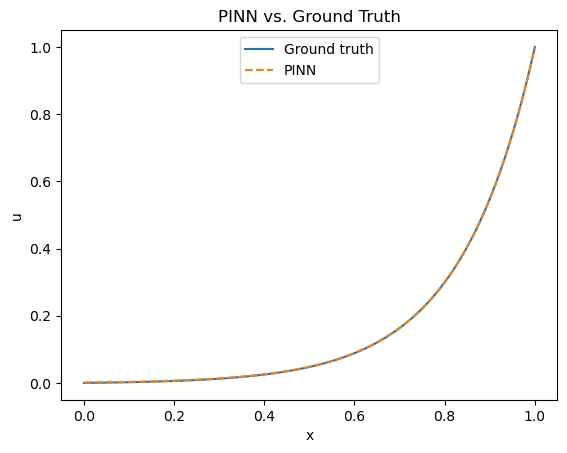

In [7]:
# plot & mse
plt.plot(x, labels_pde, label = "Ground truth"); plt.plot(x, u, '--', label = "PINN");
plt.legend(loc='upper center'); plt.title('PINN vs. Ground Truth'); plt.xlabel('x'); plt.ylabel('u');
jnp.mean(jnp.square(labels_pde - u))

Write PINN prediction & ground truth to file

In [8]:
#np.save('diffusion_cma_60s', (u, labels_pde))